# Twitter Sentiment Analysis - Clustering

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re
from langdetect import detect, detect_langs
import nltk
import enchant
from googletrans import Translator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
# nltk.download('punkt')
# nltk.download('stopwords')
from nltk.stem.porter import *
import pylab as pl
# from bs4 import BeautifulSoup
# from wordcloud import WordCloud
from sklearn.decomposition import PCA, TruncatedSVD

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score,classification_report,f1_score

# !pip install datashader
# import datashader as ds
# import datashader.transfer_functions as tf

import glob
import config
import warnings
import numpy as np
import seaborn as sns
warnings.filterwarnings('ignore')
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report,f1_score
from ibm_watson import NaturalLanguageUnderstandingV1
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from ibm_watson.natural_language_understanding_v1 import Features, SentimentOptions

In [7]:
twitter_sentiment = pd.read_csv( "C:/Users/under/Downloads/sentiment140/training.1600000.processed.noemoticon.csv",
                                header=None, encoding = "ISO-8859-1")
text_sentiment = twitter_sentiment.drop(columns=[1,2,3,4])
text_sentiment = text_sentiment.rename(columns={0: "sentiment", 5: "text"})
first_half = text_sentiment[0:400000]
second_half = text_sentiment[1200000:]
text_sentiment = pd.concat([first_half, second_half], axis=0)

         sentiment                                               text
0                0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1                0  is upset that he can't update his Facebook by ...
2                0  @Kenichan I dived many times for the ball. Man...
3                0    my whole body feels itchy and like its on fire 
4                0  @nationwideclass no, it's not behaving at all....
...            ...                                                ...
1599995          4  Just woke up. Having no school is the best fee...
1599996          4  TheWDB.com - Very cool to hear old Walt interv...
1599997          4  Are you ready for your MoJo Makeover? Ask me f...
1599998          4  Happy 38th Birthday to my boo of alll time!!! ...
1599999          4  happy #charitytuesday @theNSPCC @SparksCharity...

[800000 rows x 2 columns]


In [8]:
def preprocess_text(text):
    # TODO: Spell check

    # Remove all @usernames
    text = re.sub(r'@[^\s]+', ' ', text)
    
    # Remove URLs
    text = re.sub(
        r'(https?://(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+['
        r'a-zA-Z0-9]\.[^\s]{2,}|https?://(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})',
        ' ', text)

    # Remove punctuation and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Remove single characters
    # text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    #replace spaces with a single space
    text = re.sub(r'[\s]+', ' ', text)

    # Convert "#topic" to just "topic"
    text = re.sub(r'#([^\s]+)', r'\1', text)

    text = text.strip()

    return text

In [17]:
# apply preprocessing on sentiment texts
text_sentiment['text'] = text_sentiment['text'].apply(lambda x: preprocess_text(x))
# print(text_sentiment.head(5))
# tokenize sentiment texts
tokenize_text = text_sentiment['text'].apply(lambda x: x.split())
# print(tokenize_text)
# stem the text
stemmer = PorterStemmer()
tokenize_text = tokenize_text.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

def removecomma(text):
    result = " ".join(text)
    return result

tokenize_text = tokenize_text.apply(lambda x: removecomma(x))

0    awww that s a bummer you shoulda got david car...
1    is upset that he can t updat hi facebook by te...
2    I dive mani time for the ball manag to save th...
3         my whole bodi feel itchi and like it on fire
4    no it s not behav at all i m mad whi am i here...
Name: text, dtype: object


In [18]:
tf_idf_vect = CountVectorizer(analyzer='word',ngram_range=(1,1),stop_words='english')
tf_idf_vect.fit(tokenize_text)
desc_matrix = tf_idf_vect.transform(tokenize_text)

num_clusters = 2
km = KMeans(n_clusters=num_clusters)
km.fit(desc_matrix)
clusters = km.labels_.tolist()

In [19]:
text_sentiment['cluster'] = clusters
text_sentiment['cluster'].value_counts()

1    749564
0     50436
Name: cluster, dtype: int64

In [20]:
def PosNegFor140(num) :
    baseline = 0
    if num == 4:
        baseline = 1
    return baseline

def PosNegForCluster(num):
    baseline = 1
    if num == 1:
        baseline = 0
    return baseline
        
text_sentiment['sentiment'] = text_sentiment['sentiment'].apply(lambda x: PosNegFor140(x))
text_sentiment['cluster'] = text_sentiment['cluster'].apply(lambda x : PosNegForCluster(x))

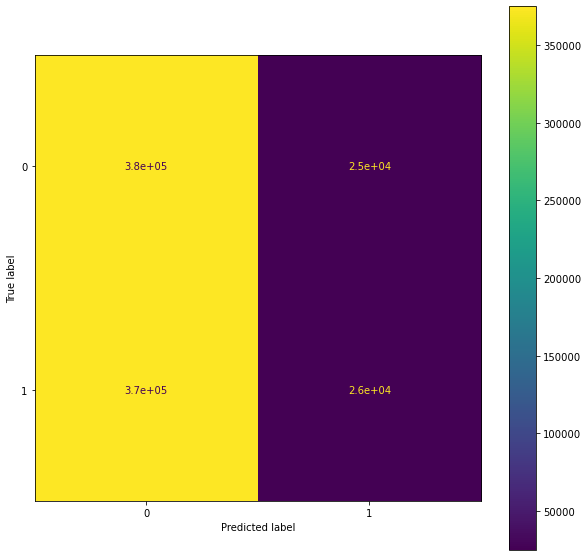

In [21]:
def eval_model(true_result, result):
    cm = confusion_matrix(result, true_result)
    fig = plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)
    c = ConfusionMatrixDisplay(cm, display_labels=range(2))
    c.plot(ax = ax)

eval_model(text_sentiment['cluster'], text_sentiment['sentiment'])

In [22]:
rate = accuracy_score(text_sentiment['sentiment'], text_sentiment['cluster'])
rate

0.501355

In [23]:
analyser = SentimentIntensityAnalyzer()
def analyse_sentiment(text, analyzer):
    if analyzer == 'VADER':
        result = analyser.polarity_scores(text)
        score = result['compound']
    elif analyzer == 'TextBlob':
        score = TextBlob(text).sentiment.polarity
        
    if score > 0:
        result = 1
    else:
        result = 0
    return result

In [24]:
text_sentiment['vader_result'] = text_sentiment['text'].apply(analyse_sentiment, analyzer='VADER')
text_sentiment['Textblob_result'] = text_sentiment['text'].apply(analyse_sentiment, analyzer='TextBlob')

0.64622625
0    409117
1    390883
Name: vader_result, dtype: int64


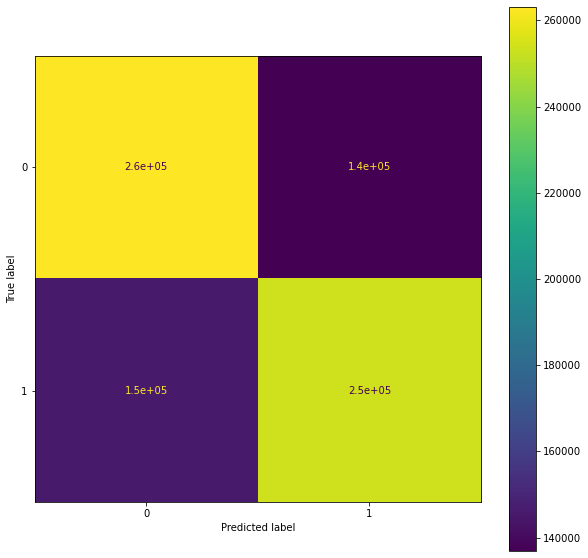

In [25]:
eval_model(text_sentiment['vader_result'], text_sentiment['sentiment'])
rate_1 = accuracy_score(text_sentiment['sentiment'], text_sentiment['vader_result'])
print(rate_1)
print(text_sentiment['vader_result'].value_counts())

0.62132625
0    449905
1    350095
Name: Textblob_result, dtype: int64


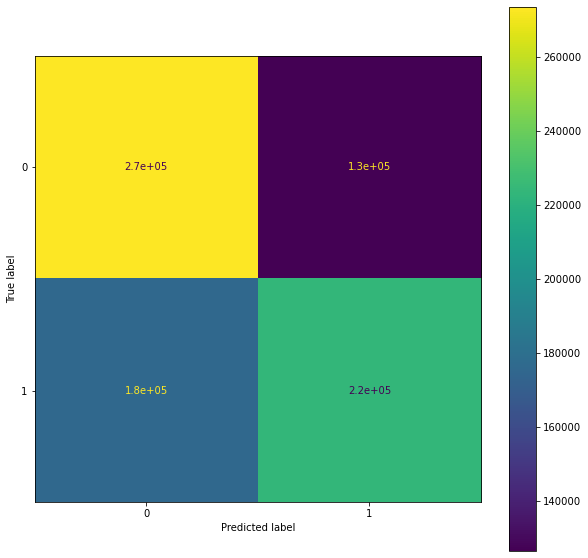

In [26]:
eval_model(text_sentiment['Textblob_result'], text_sentiment['sentiment'])
rate_2 = accuracy_score(text_sentiment['sentiment'], text_sentiment['Textblob_result'])
print(rate_2)
print(text_sentiment['Textblob_result'].value_counts())

In [57]:
apikey= "2337yJGsnhEss0FdHfqFMGWkiTAtwzxovzTCtvgNjx4t"
watson_url= "https://api.au-syd.natural-language-understanding.watson.cloud.ibm.com/instances/e18f2fe5-3e22-4eca-bdcd-802ca19b60f2"

authenticator = IAMAuthenticator(apikey)
natural_language_understanding = NaturalLanguageUnderstandingV1(
    version='2019-07-12',
    authenticator=authenticator
)

natural_language_understanding.set_service_url(watson_url)

def ibm_watson_analyser(input_text):
    score = 0
    if (input_text != ""):
        response = natural_language_understanding.analyze(
        text = input_text,
        features=Features(sentiment=SentimentOptions()),
        language='en').get_result()
        score = response['sentiment']['document']['score']
    result = 0
    if score > 0:
        result = 1
    return result
    

In [96]:
watson_first_half = text_sentiment[0:10000]
watson_sec_half = text_sentiment[790000:]
watson_text_sentiment = pd.concat([watson_first_half, watson_sec_half], axis=0)


watson_result_list=[]
def set_Interval_Watson(input_dataframe):
    for i in range(len(input_dataframe)):
        result = ibm_watson_analyser(input_dataframe['text'].tolist()[i])
        watson_result_list.append(result)
        print("index "+ str(i) + ": "+ str(result))

In [97]:
set_Interval_Watson(watson_first_half[0:2000])

index 0: 0
index 1: 0
index 2: 0
index 3: 0
index 4: 0
index 5: 0
index 6: 0
index 7: 1
index 8: 0
index 9: 0
index 10: 0
index 11: 0
index 12: 0
index 13: 0
index 14: 0
index 15: 0
index 16: 0
index 17: 0
index 18: 1
index 19: 0
index 20: 0
index 21: 0
index 22: 1
index 23: 0
index 24: 0
index 25: 0
index 26: 0
index 27: 0
index 28: 1
index 29: 0
index 30: 0
index 31: 0
index 32: 0
index 33: 0
index 34: 0
index 35: 0
index 36: 0
index 37: 0
index 38: 0
index 39: 0
index 40: 0
index 41: 0
index 42: 0
index 43: 0
index 44: 0
index 45: 1
index 46: 0
index 47: 0
index 48: 0
index 49: 0
index 50: 0
index 51: 1
index 52: 0
index 53: 0
index 54: 0
index 55: 0
index 56: 0
index 57: 0
index 58: 0
index 59: 1
index 60: 0
index 61: 0
index 62: 0
index 63: 0
index 64: 0
index 65: 0
index 66: 0
index 67: 0
index 68: 0
index 69: 1
index 70: 0
index 71: 1
index 72: 0
index 73: 1
index 74: 0
index 75: 0
index 76: 0
index 77: 0
index 78: 0
index 79: 0
index 80: 0
index 81: 0
index 82: 0
index 83: 0
in

ERROR:root:cannot analyze: downstream issue
Traceback (most recent call last):
  File "c:\users\under\appdata\local\programs\python\python37\lib\site-packages\ibm_cloud_sdk_core\base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: cannot analyze: downstream issue, Code: 500 , X-global-transaction-id: 271a2a27b282807e9304c80a62e1aee0


ApiException: Error: cannot analyze: downstream issue, Code: 500 , X-global-transaction-id: 271a2a27b282807e9304c80a62e1aee0

In [98]:
set_Interval_Watson(watson_first_half[322:2000])

index 0: 0
index 1: 0
index 2: 0
index 3: 1
index 4: 0
index 5: 0
index 6: 0
index 7: 0
index 8: 0
index 9: 0
index 10: 0
index 11: 0
index 12: 0
index 13: 0
index 14: 0
index 15: 0
index 16: 0
index 17: 0
index 18: 0
index 19: 0
index 20: 0
index 21: 0
index 22: 0
index 23: 1
index 24: 0
index 25: 0
index 26: 0
index 27: 0
index 28: 1
index 29: 1
index 30: 0
index 31: 0
index 32: 0
index 33: 0
index 34: 1
index 35: 0
index 36: 0
index 37: 0
index 38: 0
index 39: 1
index 40: 0
index 41: 0
index 42: 0
index 43: 0
index 44: 0
index 45: 0
index 46: 0
index 47: 0
index 48: 0
index 49: 0
index 50: 0
index 51: 0
index 52: 0
index 53: 0
index 54: 0
index 55: 0
index 56: 0
index 57: 0
index 58: 1
index 59: 0
index 60: 0
index 61: 0
index 62: 1
index 63: 1
index 64: 0
index 65: 0
index 66: 1
index 67: 0
index 68: 0
index 69: 0
index 70: 0
index 71: 0
index 72: 1
index 73: 0
index 74: 0
index 75: 0
index 76: 1
index 77: 0
index 78: 0
index 79: 0
index 80: 0
index 81: 0
index 82: 0
index 83: 1
in

ERROR:root:cannot analyze: downstream issue
Traceback (most recent call last):
  File "c:\users\under\appdata\local\programs\python\python37\lib\site-packages\ibm_cloud_sdk_core\base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: cannot analyze: downstream issue, Code: 500 , X-global-transaction-id: c390b121080d956e211e0470b539db3f


ApiException: Error: cannot analyze: downstream issue, Code: 500 , X-global-transaction-id: c390b121080d956e211e0470b539db3f

In [102]:
set_Interval_Watson(watson_first_half[717:2000])

index 0: 1
index 1: 0
index 2: 1
index 3: 0
index 4: 0
index 5: 1
index 6: 0
index 7: 1
index 8: 0
index 9: 0
index 10: 0
index 11: 1
index 12: 0
index 13: 0
index 14: 0
index 15: 0
index 16: 0
index 17: 0
index 18: 0
index 19: 0
index 20: 0
index 21: 1
index 22: 0
index 23: 0
index 24: 0
index 25: 1
index 26: 0
index 27: 0
index 28: 0
index 29: 1
index 30: 0
index 31: 0
index 32: 0
index 33: 1
index 34: 0
index 35: 0
index 36: 1
index 37: 0
index 38: 0
index 39: 1
index 40: 0
index 41: 0
index 42: 0
index 43: 1
index 44: 0
index 45: 0
index 46: 0
index 47: 0
index 48: 0
index 49: 0
index 50: 1
index 51: 0
index 52: 0
index 53: 0
index 54: 1
index 55: 0
index 56: 0
index 57: 0
index 58: 0
index 59: 0
index 60: 0
index 61: 0
index 62: 0
index 63: 1
index 64: 0
index 65: 1
index 66: 0
index 67: 0
index 68: 0
index 69: 0
index 70: 0
index 71: 0
index 72: 0
index 73: 0
index 74: 0
index 75: 0
index 76: 1
index 77: 0
index 78: 0
index 79: 1
index 80: 1
index 81: 0
index 82: 0
index 83: 0
in

ERROR:root:cannot analyze: downstream issue
Traceback (most recent call last):
  File "c:\users\under\appdata\local\programs\python\python37\lib\site-packages\ibm_cloud_sdk_core\base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: cannot analyze: downstream issue, Code: 500 , X-global-transaction-id: 098d08c88b0b1b80d9e80d0dacab0144


ApiException: Error: cannot analyze: downstream issue, Code: 500 , X-global-transaction-id: 098d08c88b0b1b80d9e80d0dacab0144

In [107]:
set_Interval_Watson(watson_first_half[1120:2000])

index 0: 1
index 1: 0
index 2: 0
index 3: 0
index 4: 1
index 5: 1
index 6: 0
index 7: 0
index 8: 1
index 9: 0
index 10: 0
index 11: 0
index 12: 0
index 13: 1
index 14: 0
index 15: 0
index 16: 0
index 17: 0
index 18: 0
index 19: 0
index 20: 0
index 21: 0
index 22: 0
index 23: 0
index 24: 0
index 25: 0
index 26: 0
index 27: 0
index 28: 0
index 29: 0
index 30: 0
index 31: 0
index 32: 0
index 33: 0
index 34: 0
index 35: 1
index 36: 1
index 37: 0
index 38: 0
index 39: 0
index 40: 0
index 41: 0
index 42: 0
index 43: 0
index 44: 0
index 45: 0
index 46: 0
index 47: 0
index 48: 0
index 49: 0
index 50: 1
index 51: 0
index 52: 0
index 53: 0
index 54: 0
index 55: 0
index 56: 0
index 57: 1
index 58: 0
index 59: 0
index 60: 0
index 61: 1
index 62: 0
index 63: 0
index 64: 0
index 65: 0
index 66: 1
index 67: 1
index 68: 0
index 69: 0
index 70: 0
index 71: 0
index 72: 0
index 73: 0
index 74: 0
index 75: 0
index 76: 0
index 77: 0
index 78: 0
index 79: 0
index 80: 0
index 81: 0
index 82: 0
index 83: 0
in

index 639: 0
index 640: 0
index 641: 1
index 642: 0
index 643: 0
index 644: 0
index 645: 0
index 646: 0
index 647: 1
index 648: 0
index 649: 0
index 650: 0
index 651: 1
index 652: 1
index 653: 0
index 654: 1
index 655: 0
index 656: 0
index 657: 0
index 658: 0
index 659: 0
index 660: 0
index 661: 0
index 662: 1
index 663: 0
index 664: 0
index 665: 0
index 666: 0
index 667: 0
index 668: 0
index 669: 0
index 670: 0
index 671: 0
index 672: 0
index 673: 0
index 674: 0
index 675: 1
index 676: 0
index 677: 0
index 678: 0
index 679: 0
index 680: 0
index 681: 0
index 682: 0
index 683: 0
index 684: 0
index 685: 0
index 686: 1
index 687: 0
index 688: 0
index 689: 0
index 690: 0
index 691: 0
index 692: 0
index 693: 0
index 694: 0
index 695: 0
index 696: 1
index 697: 0
index 698: 0
index 699: 0
index 700: 0
index 701: 1
index 702: 0
index 703: 0
index 704: 0
index 705: 0
index 706: 0
index 707: 0
index 708: 0
index 709: 1
index 710: 0
index 711: 0
index 712: 1
index 713: 0
index 714: 1
index 715: 0

In [109]:
set_Interval_Watson(watson_first_half[2000:3000])

index 0: 0
index 1: 1
index 2: 0
index 3: 0
index 4: 1
index 5: 0
index 6: 1
index 7: 1
index 8: 0
index 9: 0
index 10: 0
index 11: 0
index 12: 0
index 13: 0
index 14: 0
index 15: 0
index 16: 0
index 17: 0
index 18: 0
index 19: 1
index 20: 0
index 21: 0
index 22: 0
index 23: 0
index 24: 0
index 25: 0
index 26: 0
index 27: 0
index 28: 0
index 29: 0
index 30: 0
index 31: 0
index 32: 0
index 33: 0
index 34: 0
index 35: 1
index 36: 0
index 37: 0
index 38: 0
index 39: 0
index 40: 1
index 41: 0
index 42: 0
index 43: 1
index 44: 0
index 45: 0
index 46: 1
index 47: 0
index 48: 0
index 49: 0
index 50: 1
index 51: 0
index 52: 0
index 53: 0
index 54: 0
index 55: 0
index 56: 0
index 57: 0
index 58: 0
index 59: 1
index 60: 0
index 61: 0
index 62: 0
index 63: 0
index 64: 1
index 65: 0
index 66: 0
index 67: 0
index 68: 0
index 69: 0
index 70: 1
index 71: 0
index 72: 1
index 73: 0
index 74: 1
index 75: 0
index 76: 0
index 77: 0
index 78: 0
index 79: 0
index 80: 1
index 81: 0
index 82: 1
index 83: 1
in

index 639: 0
index 640: 1
index 641: 0
index 642: 1
index 643: 0
index 644: 1
index 645: 0
index 646: 0
index 647: 0
index 648: 1
index 649: 0
index 650: 0
index 651: 1
index 652: 0
index 653: 0
index 654: 0
index 655: 0
index 656: 0
index 657: 0
index 658: 0
index 659: 0
index 660: 1
index 661: 0
index 662: 0
index 663: 0
index 664: 0
index 665: 0
index 666: 0
index 667: 0
index 668: 0
index 669: 1
index 670: 1
index 671: 0
index 672: 0
index 673: 0
index 674: 0
index 675: 0
index 676: 0
index 677: 0
index 678: 0
index 679: 0
index 680: 1
index 681: 1
index 682: 0
index 683: 0
index 684: 0
index 685: 0
index 686: 1
index 687: 0
index 688: 1
index 689: 0
index 690: 1
index 691: 0
index 692: 0
index 693: 0
index 694: 0
index 695: 0
index 696: 0
index 697: 0
index 698: 1
index 699: 0
index 700: 0
index 701: 0
index 702: 0
index 703: 0
index 704: 0
index 705: 1
index 706: 0
index 707: 0
index 708: 1
index 709: 0
index 710: 0
index 711: 0
index 712: 0
index 713: 0
index 714: 0
index 715: 0

In [110]:
set_Interval_Watson(watson_first_half[3000:4000])

index 0: 1
index 1: 0
index 2: 0
index 3: 0
index 4: 0
index 5: 1
index 6: 0
index 7: 0
index 8: 1
index 9: 0
index 10: 0
index 11: 0
index 12: 1
index 13: 0
index 14: 0
index 15: 0
index 16: 0
index 17: 0
index 18: 0
index 19: 0
index 20: 0
index 21: 0
index 22: 0
index 23: 0
index 24: 0
index 25: 0
index 26: 0
index 27: 0
index 28: 0
index 29: 0
index 30: 0
index 31: 0
index 32: 1
index 33: 1
index 34: 1
index 35: 1
index 36: 0
index 37: 0
index 38: 0
index 39: 1
index 40: 0
index 41: 0
index 42: 0
index 43: 0
index 44: 0
index 45: 0
index 46: 0
index 47: 0
index 48: 0
index 49: 0
index 50: 0
index 51: 0
index 52: 0
index 53: 0
index 54: 0
index 55: 0
index 56: 0
index 57: 0
index 58: 0
index 59: 0
index 60: 0
index 61: 0
index 62: 0
index 63: 0
index 64: 0
index 65: 0
index 66: 0
index 67: 0
index 68: 0
index 69: 0
index 70: 0
index 71: 0
index 72: 0
index 73: 0
index 74: 0
index 75: 0
index 76: 1
index 77: 0
index 78: 0
index 79: 1
index 80: 0
index 81: 0
index 82: 0
index 83: 0
in

index 639: 0
index 640: 0
index 641: 0
index 642: 0
index 643: 0
index 644: 0
index 645: 0
index 646: 0
index 647: 0
index 648: 0
index 649: 0
index 650: 0
index 651: 0
index 652: 0
index 653: 0
index 654: 0
index 655: 0
index 656: 0
index 657: 0
index 658: 0
index 659: 0
index 660: 0
index 661: 1
index 662: 0
index 663: 0
index 664: 0
index 665: 0
index 666: 0
index 667: 0
index 668: 1
index 669: 1
index 670: 0
index 671: 0
index 672: 0
index 673: 0
index 674: 0
index 675: 0
index 676: 0
index 677: 0
index 678: 0
index 679: 0
index 680: 0
index 681: 1
index 682: 0
index 683: 0
index 684: 0
index 685: 1
index 686: 0
index 687: 1
index 688: 0
index 689: 0
index 690: 0
index 691: 0
index 692: 0
index 693: 0
index 694: 1
index 695: 1
index 696: 0
index 697: 0
index 698: 0
index 699: 0
index 700: 0
index 701: 1
index 702: 1
index 703: 0
index 704: 0
index 705: 0
index 706: 0
index 707: 0
index 708: 1
index 709: 0
index 710: 0
index 711: 0
index 712: 0
index 713: 0
index 714: 1
index 715: 0

In [111]:
set_Interval_Watson(watson_first_half[4000:5000])

index 0: 1
index 1: 0
index 2: 0
index 3: 0
index 4: 0
index 5: 0
index 6: 0
index 7: 0
index 8: 0
index 9: 1
index 10: 1
index 11: 0
index 12: 0
index 13: 0
index 14: 1
index 15: 0
index 16: 0
index 17: 0
index 18: 0
index 19: 0
index 20: 0
index 21: 0
index 22: 0
index 23: 0
index 24: 0
index 25: 0
index 26: 0
index 27: 0
index 28: 1
index 29: 0
index 30: 0
index 31: 0
index 32: 0
index 33: 0
index 34: 0
index 35: 0
index 36: 0
index 37: 1
index 38: 0
index 39: 0
index 40: 0
index 41: 1
index 42: 0
index 43: 0
index 44: 0
index 45: 0
index 46: 0
index 47: 0
index 48: 0
index 49: 0
index 50: 0
index 51: 0
index 52: 0
index 53: 0
index 54: 0
index 55: 0
index 56: 1
index 57: 0
index 58: 0
index 59: 0
index 60: 0
index 61: 0
index 62: 0
index 63: 0
index 64: 0
index 65: 0
index 66: 1
index 67: 1
index 68: 0
index 69: 0
index 70: 0
index 71: 0
index 72: 0
index 73: 0
index 74: 0
index 75: 0
index 76: 1
index 77: 0
index 78: 0
index 79: 0
index 80: 0
index 81: 1
index 82: 0
index 83: 0
in

index 639: 0
index 640: 0
index 641: 0
index 642: 0
index 643: 0
index 644: 0
index 645: 1
index 646: 0
index 647: 0
index 648: 1
index 649: 0
index 650: 1
index 651: 1
index 652: 0
index 653: 1
index 654: 0
index 655: 0
index 656: 0
index 657: 0
index 658: 0
index 659: 0
index 660: 0
index 661: 0
index 662: 0
index 663: 0
index 664: 0
index 665: 1
index 666: 0
index 667: 0
index 668: 0
index 669: 0
index 670: 0
index 671: 0
index 672: 0
index 673: 0
index 674: 0
index 675: 0
index 676: 0
index 677: 1
index 678: 0
index 679: 1
index 680: 0
index 681: 0
index 682: 0
index 683: 0
index 684: 0
index 685: 0
index 686: 0
index 687: 0
index 688: 0
index 689: 0
index 690: 0
index 691: 0
index 692: 0
index 693: 1
index 694: 0
index 695: 0
index 696: 0
index 697: 0
index 698: 0
index 699: 0
index 700: 1
index 701: 0
index 702: 1
index 703: 0
index 704: 0
index 705: 0
index 706: 0
index 707: 0
index 708: 0
index 709: 0
index 710: 0
index 711: 1
index 712: 0
index 713: 1
index 714: 0
index 715: 0

In [112]:
set_Interval_Watson(watson_sec_half[0:1000])

index 0: 0
index 1: 1
index 2: 1
index 3: 0
index 4: 0
index 5: 0
index 6: 1
index 7: 1
index 8: 1
index 9: 0
index 10: 1
index 11: 1
index 12: 1
index 13: 0
index 14: 1
index 15: 1
index 16: 1
index 17: 1
index 18: 1
index 19: 0
index 20: 1
index 21: 1
index 22: 1
index 23: 1
index 24: 1
index 25: 1
index 26: 0
index 27: 1
index 28: 1
index 29: 1
index 30: 1
index 31: 1
index 32: 1
index 33: 1
index 34: 1
index 35: 0
index 36: 1
index 37: 1
index 38: 1
index 39: 0
index 40: 0
index 41: 0
index 42: 0
index 43: 1
index 44: 1
index 45: 0
index 46: 1
index 47: 0
index 48: 1
index 49: 1
index 50: 0
index 51: 0
index 52: 1
index 53: 0
index 54: 1
index 55: 0
index 56: 0
index 57: 0
index 58: 0
index 59: 1
index 60: 1
index 61: 1
index 62: 0
index 63: 0
index 64: 0
index 65: 1
index 66: 1
index 67: 1
index 68: 1
index 69: 1
index 70: 1
index 71: 0
index 72: 1
index 73: 0
index 74: 1
index 75: 0
index 76: 1
index 77: 0
index 78: 0
index 79: 1
index 80: 0
index 81: 0
index 82: 1
index 83: 0
in

index 639: 1
index 640: 1
index 641: 0
index 642: 0
index 643: 0
index 644: 1
index 645: 0
index 646: 0
index 647: 1
index 648: 1
index 649: 1
index 650: 0
index 651: 0
index 652: 1
index 653: 0
index 654: 0
index 655: 1
index 656: 1
index 657: 0
index 658: 0
index 659: 1
index 660: 1
index 661: 0
index 662: 1
index 663: 0
index 664: 0
index 665: 1
index 666: 0
index 667: 0
index 668: 1
index 669: 1
index 670: 1
index 671: 1
index 672: 1
index 673: 1
index 674: 0
index 675: 1
index 676: 1
index 677: 1
index 678: 1
index 679: 1
index 680: 0
index 681: 1
index 682: 0
index 683: 0
index 684: 1
index 685: 1
index 686: 1
index 687: 1
index 688: 1
index 689: 0
index 690: 1
index 691: 0
index 692: 0
index 693: 1
index 694: 0
index 695: 0
index 696: 1
index 697: 1
index 698: 1
index 699: 0
index 700: 1
index 701: 1
index 702: 1
index 703: 0
index 704: 1
index 705: 1
index 706: 1
index 707: 1
index 708: 0
index 709: 0
index 710: 1
index 711: 0
index 712: 1
index 713: 1
index 714: 1
index 715: 0

In [113]:
set_Interval_Watson(watson_sec_half[1000:2000])

index 0: 1
index 1: 0
index 2: 1
index 3: 1
index 4: 1
index 5: 0
index 6: 0
index 7: 0
index 8: 1
index 9: 0
index 10: 0
index 11: 1
index 12: 0
index 13: 1
index 14: 0
index 15: 0
index 16: 0
index 17: 0
index 18: 1
index 19: 0
index 20: 1
index 21: 0
index 22: 1
index 23: 1
index 24: 1
index 25: 1
index 26: 1
index 27: 1
index 28: 0
index 29: 1
index 30: 0
index 31: 0
index 32: 1
index 33: 1
index 34: 1
index 35: 1
index 36: 0
index 37: 0
index 38: 1
index 39: 0
index 40: 1
index 41: 1
index 42: 1
index 43: 1
index 44: 0
index 45: 1
index 46: 0
index 47: 0
index 48: 1
index 49: 1
index 50: 0
index 51: 1
index 52: 1
index 53: 0
index 54: 1
index 55: 1
index 56: 0
index 57: 1
index 58: 1
index 59: 1
index 60: 1
index 61: 1
index 62: 1
index 63: 0
index 64: 0
index 65: 1
index 66: 1
index 67: 1
index 68: 0
index 69: 0
index 70: 1
index 71: 1
index 72: 1
index 73: 0
index 74: 0
index 75: 0
index 76: 1
index 77: 0
index 78: 1
index 79: 0
index 80: 1
index 81: 0
index 82: 1
index 83: 1
in

index 639: 1
index 640: 0
index 641: 0
index 642: 1
index 643: 1
index 644: 0
index 645: 0
index 646: 0
index 647: 0
index 648: 0
index 649: 1
index 650: 0
index 651: 1
index 652: 1
index 653: 1
index 654: 0
index 655: 1
index 656: 1
index 657: 1
index 658: 0
index 659: 0
index 660: 0
index 661: 1
index 662: 1
index 663: 1
index 664: 0
index 665: 0
index 666: 0
index 667: 1
index 668: 1
index 669: 0
index 670: 1
index 671: 1
index 672: 1
index 673: 1
index 674: 0
index 675: 1
index 676: 1
index 677: 1
index 678: 0
index 679: 1
index 680: 1
index 681: 0
index 682: 1
index 683: 0
index 684: 1
index 685: 0
index 686: 0
index 687: 1
index 688: 1
index 689: 1
index 690: 1
index 691: 0
index 692: 1
index 693: 1
index 694: 0
index 695: 0
index 696: 0
index 697: 0
index 698: 1
index 699: 1
index 700: 1
index 701: 0
index 702: 1
index 703: 0
index 704: 1
index 705: 1
index 706: 1
index 707: 1
index 708: 1
index 709: 1
index 710: 1
index 711: 1
index 712: 0
index 713: 1
index 714: 0
index 715: 1

In [114]:
set_Interval_Watson(watson_sec_half[2000:3000])

index 0: 1
index 1: 1
index 2: 1
index 3: 0
index 4: 1
index 5: 0
index 6: 1
index 7: 1
index 8: 1
index 9: 1
index 10: 1
index 11: 1
index 12: 1
index 13: 1
index 14: 1
index 15: 0
index 16: 1
index 17: 1
index 18: 0
index 19: 1
index 20: 1
index 21: 0
index 22: 1
index 23: 1
index 24: 0
index 25: 1
index 26: 1
index 27: 1
index 28: 1
index 29: 1
index 30: 1
index 31: 0
index 32: 0
index 33: 1
index 34: 0
index 35: 1
index 36: 0
index 37: 1
index 38: 1
index 39: 1
index 40: 0
index 41: 1
index 42: 1
index 43: 1
index 44: 1
index 45: 1
index 46: 0
index 47: 1
index 48: 1
index 49: 0
index 50: 1
index 51: 1
index 52: 1
index 53: 1
index 54: 0
index 55: 1
index 56: 1
index 57: 1
index 58: 1
index 59: 0
index 60: 0
index 61: 1
index 62: 1
index 63: 0
index 64: 1
index 65: 1
index 66: 1
index 67: 0
index 68: 1
index 69: 1
index 70: 1
index 71: 1
index 72: 0
index 73: 1
index 74: 0
index 75: 1
index 76: 1
index 77: 0
index 78: 1
index 79: 1
index 80: 1
index 81: 0
index 82: 1
index 83: 1
in

index 639: 0
index 640: 1
index 641: 1
index 642: 0
index 643: 1
index 644: 0
index 645: 0
index 646: 1
index 647: 1
index 648: 1
index 649: 1
index 650: 0
index 651: 0
index 652: 0
index 653: 1
index 654: 1
index 655: 0
index 656: 0
index 657: 0
index 658: 1
index 659: 0
index 660: 1
index 661: 0
index 662: 1
index 663: 0
index 664: 1
index 665: 1
index 666: 1
index 667: 0
index 668: 1
index 669: 1
index 670: 1
index 671: 0
index 672: 0
index 673: 0
index 674: 1
index 675: 1
index 676: 1
index 677: 1
index 678: 1
index 679: 0
index 680: 1
index 681: 1
index 682: 1
index 683: 0
index 684: 1
index 685: 1
index 686: 1
index 687: 0
index 688: 1
index 689: 0
index 690: 1
index 691: 1
index 692: 1
index 693: 0
index 694: 1
index 695: 0
index 696: 0
index 697: 1
index 698: 1
index 699: 1
index 700: 0
index 701: 0
index 702: 1
index 703: 1
index 704: 1
index 705: 1
index 706: 1
index 707: 0
index 708: 1
index 709: 0
index 710: 1
index 711: 0
index 712: 1
index 713: 1
index 714: 1
index 715: 0

In [115]:
set_Interval_Watson(watson_sec_half[3000:4000])

index 0: 0
index 1: 1
index 2: 0
index 3: 1
index 4: 0
index 5: 0
index 6: 0
index 7: 1
index 8: 0
index 9: 1
index 10: 1
index 11: 1
index 12: 0
index 13: 1
index 14: 0
index 15: 0
index 16: 0
index 17: 1
index 18: 1
index 19: 0
index 20: 1
index 21: 0
index 22: 0
index 23: 1
index 24: 1
index 25: 1
index 26: 0
index 27: 0
index 28: 1
index 29: 1
index 30: 1
index 31: 1
index 32: 1
index 33: 1
index 34: 1
index 35: 0
index 36: 0
index 37: 0
index 38: 1
index 39: 1
index 40: 0
index 41: 1
index 42: 0
index 43: 1
index 44: 0
index 45: 1
index 46: 0
index 47: 0
index 48: 0
index 49: 1
index 50: 0
index 51: 1
index 52: 0
index 53: 1
index 54: 1
index 55: 1
index 56: 0
index 57: 0
index 58: 0
index 59: 0
index 60: 1
index 61: 1
index 62: 1
index 63: 1
index 64: 0
index 65: 1
index 66: 1
index 67: 0
index 68: 0
index 69: 1
index 70: 1
index 71: 0
index 72: 1
index 73: 1
index 74: 1
index 75: 0
index 76: 1
index 77: 1
index 78: 1
index 79: 1
index 80: 1
index 81: 0
index 82: 1
index 83: 0
in

index 639: 0
index 640: 1
index 641: 1
index 642: 0
index 643: 0
index 644: 1
index 645: 0
index 646: 0
index 647: 1
index 648: 1
index 649: 0
index 650: 0
index 651: 0
index 652: 1
index 653: 1
index 654: 0
index 655: 1
index 656: 1
index 657: 1
index 658: 1
index 659: 0
index 660: 1
index 661: 1
index 662: 0
index 663: 0
index 664: 1
index 665: 1
index 666: 0
index 667: 0
index 668: 0
index 669: 1
index 670: 1
index 671: 1
index 672: 1
index 673: 1
index 674: 1
index 675: 1
index 676: 1
index 677: 1
index 678: 1
index 679: 1
index 680: 0
index 681: 1
index 682: 0
index 683: 1
index 684: 1
index 685: 1
index 686: 1
index 687: 1
index 688: 1
index 689: 1
index 690: 1
index 691: 0
index 692: 0
index 693: 0
index 694: 1
index 695: 1
index 696: 1
index 697: 1
index 698: 0
index 699: 0
index 700: 0
index 701: 1
index 702: 0
index 703: 1
index 704: 1
index 705: 1
index 706: 1
index 707: 1
index 708: 0
index 709: 1
index 710: 1
index 711: 1
index 712: 1
index 713: 0
index 714: 0
index 715: 1

In [116]:
set_Interval_Watson(watson_sec_half[4000:5000])

index 0: 1
index 1: 1
index 2: 0
index 3: 0
index 4: 0
index 5: 1
index 6: 1
index 7: 1
index 8: 0
index 9: 1
index 10: 0
index 11: 0
index 12: 1
index 13: 1
index 14: 1
index 15: 1
index 16: 0
index 17: 1
index 18: 1
index 19: 1
index 20: 0
index 21: 0
index 22: 1
index 23: 1
index 24: 1
index 25: 1
index 26: 1
index 27: 1
index 28: 0
index 29: 1
index 30: 0
index 31: 0
index 32: 1
index 33: 1
index 34: 1
index 35: 1
index 36: 1
index 37: 1
index 38: 1
index 39: 1
index 40: 1
index 41: 1
index 42: 1
index 43: 0
index 44: 0
index 45: 0
index 46: 0
index 47: 0
index 48: 0
index 49: 0
index 50: 1
index 51: 1
index 52: 1
index 53: 1
index 54: 0
index 55: 1
index 56: 1
index 57: 1
index 58: 1
index 59: 1
index 60: 1
index 61: 0
index 62: 0
index 63: 0
index 64: 0
index 65: 1
index 66: 1
index 67: 1
index 68: 1
index 69: 0
index 70: 1
index 71: 1
index 72: 1
index 73: 1
index 74: 1
index 75: 1
index 76: 1
index 77: 1
index 78: 0
index 79: 1
index 80: 1
index 81: 1
index 82: 1
index 83: 1
in

index 639: 0
index 640: 1
index 641: 1
index 642: 1
index 643: 1
index 644: 1
index 645: 0
index 646: 0
index 647: 1
index 648: 1
index 649: 1
index 650: 1
index 651: 1
index 652: 0
index 653: 0
index 654: 0
index 655: 1
index 656: 1
index 657: 0
index 658: 0
index 659: 1
index 660: 1
index 661: 1
index 662: 1
index 663: 1
index 664: 0
index 665: 0
index 666: 0
index 667: 1
index 668: 1
index 669: 0
index 670: 1
index 671: 0
index 672: 0
index 673: 0
index 674: 1
index 675: 1
index 676: 1
index 677: 0
index 678: 0
index 679: 1
index 680: 1
index 681: 0
index 682: 0
index 683: 0
index 684: 1
index 685: 1
index 686: 1
index 687: 0
index 688: 0
index 689: 1
index 690: 1
index 691: 1
index 692: 0
index 693: 1
index 694: 0
index 695: 1
index 696: 1
index 697: 1
index 698: 0
index 699: 0
index 700: 1
index 701: 0
index 702: 1
index 703: 0
index 704: 1
index 705: 1
index 706: 0
index 707: 0
index 708: 1
index 709: 1
index 710: 1
index 711: 1
index 712: 1
index 713: 0
index 714: 1
index 715: 1

ERROR:root:<HTML><HEAD>
<TITLE>Service Unavailable</TITLE>
</HEAD><BODY>
<H1>Service Unavailable - Zero size object</H1>
The server is temporarily unable to service your request.  Please try again
later.<P>
Reference&#32;&#35;15&#46;7834768&#46;1590675378&#46;daab9cf
</BODY></HTML>
Traceback (most recent call last):
  File "c:\users\under\appdata\local\programs\python\python37\lib\site-packages\ibm_cloud_sdk_core\base_service.py", line 229, in send
    response.status_code, error_message, http_response=response)
ibm_cloud_sdk_core.api_exception.ApiException: Error: <HTML><HEAD>
<TITLE>Service Unavailable</TITLE>
</HEAD><BODY>
<H1>Service Unavailable - Zero size object</H1>
The server is temporarily unable to service your request.  Please try again
later.<P>
Reference&#32;&#35;15&#46;7834768&#46;1590675378&#46;daab9cf
</BODY></HTML>
, Code: 503


index 758: 1


ApiException: Error: <HTML><HEAD>
<TITLE>Service Unavailable</TITLE>
</HEAD><BODY>
<H1>Service Unavailable - Zero size object</H1>
The server is temporarily unable to service your request.  Please try again
later.<P>
Reference&#32;&#35;15&#46;7834768&#46;1590675378&#46;daab9cf
</BODY></HTML>
, Code: 503

In [119]:
set_Interval_Watson(watson_sec_half[4759:5000])

index 0: 0
index 1: 1
index 2: 1
index 3: 0
index 4: 1
index 5: 1
index 6: 0
index 7: 1
index 8: 1
index 9: 1
index 10: 1
index 11: 1
index 12: 1
index 13: 1
index 14: 0
index 15: 0
index 16: 0
index 17: 1
index 18: 0
index 19: 0
index 20: 1
index 21: 1
index 22: 1
index 23: 0
index 24: 0
index 25: 0
index 26: 0
index 27: 0
index 28: 1
index 29: 1
index 30: 0
index 31: 0
index 32: 1
index 33: 0
index 34: 0
index 35: 0
index 36: 0
index 37: 1
index 38: 0
index 39: 0
index 40: 1
index 41: 1
index 42: 1
index 43: 0
index 44: 1
index 45: 0
index 46: 1
index 47: 0
index 48: 0
index 49: 0
index 50: 1
index 51: 0
index 52: 1
index 53: 0
index 54: 1
index 55: 1
index 56: 1
index 57: 1
index 58: 0
index 59: 0
index 60: 1
index 61: 0
index 62: 1
index 63: 0
index 64: 0
index 65: 1
index 66: 0
index 67: 0
index 68: 1
index 69: 1
index 70: 0
index 71: 1
index 72: 1
index 73: 1
index 74: 1
index 75: 0
index 76: 1
index 77: 1
index 78: 1
index 79: 0
index 80: 1
index 81: 1
index 82: 1
index 83: 1
in

In [120]:
print(len(watson_result_list))

10000


In [124]:
watson_first_half_5000 = watson_first_half[0:5000]
watson_sec_half_5000 = watson_sec_half[0:5000]
text_sentiment_10K = pd.concat([watson_first_half_5000, watson_sec_half_5000], axis=0)
print(text_sentiment_10K)

         sentiment                                               text  \
0                0  Awww that s a bummer You shoulda got David Car...   
1                0  is upset that he can t update his Facebook by ...   
2                0  I dived many times for the ball Managed to sav...   
3                0     my whole body feels itchy and like its on fire   
4                0  no it s not behaving at all i m mad why am i h...   
...            ...                                                ...   
1594995          1      anxious to serve dinner with everyone tonight   
1594996          1                              Happy Birthday Andrew   
1594997          1  The return of my favorite webshow fiveandahalf...   
1594998          1                       what lesson do you have next   
1594999          1     Does that mean it s ready and I can pick it up   

         cluster  vader_result  Textblob_result  
0              1             0                1  
1              0       

In [125]:
text_sentiment_10K['watson_result'] = watson_result_list
print(text_sentiment_10K)

         sentiment                                               text  \
0                0  Awww that s a bummer You shoulda got David Car...   
1                0  is upset that he can t update his Facebook by ...   
2                0  I dived many times for the ball Managed to sav...   
3                0     my whole body feels itchy and like its on fire   
4                0  no it s not behaving at all i m mad why am i h...   
...            ...                                                ...   
1594995          1      anxious to serve dinner with everyone tonight   
1594996          1                              Happy Birthday Andrew   
1594997          1  The return of my favorite webshow fiveandahalf...   
1594998          1                       what lesson do you have next   
1594999          1     Does that mean it s ready and I can pick it up   

         cluster  vader_result  Textblob_result  watson_result  
0              1             0                1           

0.7304
0    5972
1    4028
Name: watson_result, dtype: int64


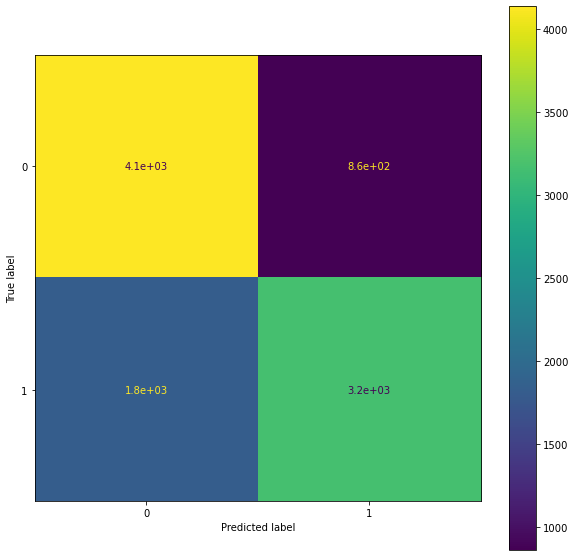

In [126]:
eval_model(text_sentiment_10K['watson_result'], text_sentiment_10K['sentiment'])
rate_3 = accuracy_score(text_sentiment_10K['sentiment'], text_sentiment_10K['watson_result'])
print(rate_3)
print(text_sentiment_10K['watson_result'].value_counts())

In [127]:
col_name = ['True_Negative', 'False_Positive', 'False_Negative', 'True_Positive']
columns = ['cluster','vader_result','Textblob_result', 'watson_result']
def matrix_and_array(target_column, columns):
    matrix_list = []
    for i in columns:
        create_matrix = confusion_matrix(text_sentiment_10K[target_column], text_sentiment_10K[i])
        create_vector = np.asarray(create_matrix).reshape(-1)
        matrix = list(create_vector)
        matrix_list.append(matrix)  
    return matrix_list

index = ['KMeans', 'VADER', 'TextBlob', 'IBM Watson']
matrix_list = matrix_and_array('sentiment', columns)
truth = pd.DataFrame(matrix_list, columns = col_name, index = index)
truth


,True_Negative,False_Positive,False_Negative,True_Positive
KMeans,4694,306,4549,451
VADER,3353,1647,1887,3113
TextBlob,3420,1580,2206,2794
IBM Watson,4138,862,1834,3166


In [128]:
precision = []
recall = []
accuracy = []
for index ,TN, FP, FN, TP in truth.itertuples():
    p = TP/(TP + FP)
    r = TP/(TP+FN)
    a = (TP + TN)/(TN + FP + FN +TP)
    precision.append(round(p,2))
    recall.append(round(r,2))
    accuracy.append(round(a,2))
    
data = [accuracy, precision, recall]
evaluate = pd.DataFrame(data, columns = ['KMeans','VADER', 'TextBlob', 'IBM Watson'], 
                        index = ['Accuracy_Score', 'Precision', 'Recall']).T.sort_values('Accuracy_Score', ascending= False)
evaluate

,Accuracy_Score,Precision,Recall
IBM Watson,0.73,0.79,0.63
VADER,0.65,0.65,0.62
TextBlob,0.62,0.64,0.56
KMeans,0.51,0.60,0.09
